In [1]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

2022-04-16 13:33:58.882402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:33:58.893345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:33:58.893975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare training, validation and test data

In [3]:
def create_lstm_data(X, y, k):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    X_data = np.zeros([X.shape[0]-k, k, X.shape[1]])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(k, X.shape[0]):
        cur_sequence = X[i-k: i, :]
        
        X_data[i-k,:, :] = cur_sequence.reshape(1, k, X_data.shape[2])
        y_data.append(y[i-1])
    
    return X_data, np.asarray(y_data)

In [4]:
df_train = pd.read_csv("./data/preprocessed_data.csv")
df_test = pd.read_csv("./data/preprocessed_validation_data.csv")

# Concat with keys
temp = pd.get_dummies(pd.concat([df_train,df_test],keys=[0,1]), columns=['time_of_day', 'time_of_week', 'time_of_year'])

# Selecting data from multi index 
df_train, df_test = temp.xs(0),temp.xs(1)

scaler = MinMaxScaler()
scaling_columns = ['hydro', 'micro', 'thermal', 'wind', 'total', 'y', 'sys_reg', 'flow', 'y_prev']
df_train[scaling_columns] = scaler.fit_transform(df_train[scaling_columns])
df_test[scaling_columns] = scaler.transform(df_test[scaling_columns])
df_train["y_prev"] = df_train["y"].shift(1)
df_train = df_train.dropna()
df_test["y_prev"] = df_test["y"].shift(1)
df_test = df_test.dropna()

df_train = df_train[[c for c in df_train if c not in ['y_prev']] 
       + ['y_prev']]

df_test = df_test[[c for c in df_test if c not in ['y_prev']] 
       + ['y_prev']]
df_train

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,hydro,micro,thermal,wind,total,y,sys_reg,flow,time_of_day_0,time_of_day_1,...,time_of_year_3,time_of_year_4,time_of_year_5,time_of_year_6,time_of_year_7,time_of_year_8,time_of_year_9,time_of_year_10,time_of_year_11,y_prev
1,0.401064,0.230675,0.331754,0.440333,0.391697,0.414003,0.825949,0.141777,0,0,...,0,0,0,0,0,0,0,0,0,0.416135
2,0.401064,0.230675,0.331754,0.440333,0.391697,0.404623,0.825949,0.141777,0,0,...,0,0,0,0,0,0,0,0,0,0.414003
3,0.401064,0.230675,0.331754,0.440333,0.391697,0.395277,0.825949,0.141777,0,0,...,0,0,0,0,0,0,0,0,0,0.404623
4,0.401064,0.230675,0.331754,0.440333,0.391697,0.382635,0.825949,0.141777,0,0,...,0,0,0,0,0,0,0,0,0,0.395277
5,0.401064,0.230675,0.331754,0.440333,0.391697,0.378400,0.825949,0.141777,0,0,...,0,0,0,0,0,0,0,0,0,0.382635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218471,0.561364,0.418793,0.739336,0.629675,0.582611,0.351701,0.810127,0.517491,0,0,...,0,0,0,0,0,0,0,0,0,0.351498
218472,0.561364,0.418793,0.739336,0.629675,0.582611,0.347402,0.810127,0.517491,0,0,...,0,0,0,0,0,0,0,0,0,0.351701
218473,0.561364,0.418793,0.739336,0.629675,0.582611,0.335733,0.810127,0.517491,0,0,...,0,0,0,0,0,0,0,0,0,0.347402
218474,0.561364,0.418793,0.739336,0.629675,0.582611,0.338359,0.810127,0.517491,0,0,...,0,0,0,0,0,0,0,0,0,0.335733


In [5]:
y = df_train.pop("y").values.astype('float32')
X = df_train.values.astype('float32')
del df_train

no_rows = X.shape[0]
data_valid = X[int(no_rows*0.8):,:]
y_valid = y[int(no_rows*0.8):]
data_train = X[:int(no_rows*0.8),:]
y_train = y[:int(no_rows*0.8)]

# Setup and train model

In [6]:
def LSTM_model(X_train, y_train, X_valid, y_valid, k):
    # Define and compile LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(k, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dropout(0.2))
    #model.add(LSTM(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1, "tanh"))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mse')#,  metrics=[''])
    # Early stopping and best model checkpoint parameters
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=2, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', mode='min', verbose=2, save_best_only=True)
    # Train the model 
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=20, verbose=2, callbacks=[mc])

In [7]:
seq_len = 50

X_train, y_train = create_lstm_data(data_train, y_train, seq_len)
X_valid, y_valid = create_lstm_data(data_valid, y_valid, seq_len)

LSTM_model(X_train, y_train, X_valid, y_valid, seq_len)

2022-04-16 13:34:19.372324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 13:34:19.373030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:34:19.373743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 13:34:19.374353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/20


2022-04-16 13:34:28.024514: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200



Epoch 1: val_loss improved from inf to 0.00120, saving model to best_model.h5
5461/5461 - 63s - loss: 0.0030 - val_loss: 0.0012 - 63s/epoch - 12ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.00120 to 0.00095, saving model to best_model.h5
5461/5461 - 53s - loss: 0.0011 - val_loss: 9.5181e-04 - 53s/epoch - 10ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.00095 to 0.00080, saving model to best_model.h5
5461/5461 - 52s - loss: 8.3913e-04 - val_loss: 8.0429e-04 - 52s/epoch - 10ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.00080 to 0.00072, saving model to best_model.h5
5461/5461 - 53s - loss: 7.0157e-04 - val_loss: 7.2156e-04 - 53s/epoch - 10ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.00072 to 0.00061, saving model to best_model.h5
5461/5461 - 52s - loss: 5.9288e-04 - val_loss: 6.0904e-04 - 52s/epoch - 10ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.00061 to 0.00046, saving model to best_model.h5
5461/5461 - 52s - loss: 4.8950e-04 - val_loss: 4.5719

# Validate

In [8]:
seq_len = 50
model = keras.models.load_model('best_model.h5')
forecast_window_len = 24
start_ind = 200
model_input = X[start_ind:start_ind+seq_len]
forecasts = []
for pred_no in range(1, forecast_window_len+1):
    #print(model_input)
    #print("pred_no: ", model_input)
    #forecast = [[-666]] # 
    forecast = model(np.array([model_input]))
    forecasts.append(forecast[0][0])
    model_input = X[start_ind+pred_no:start_ind+pred_no+seq_len]
    #print("model_input", model_input[-(pred_no+1):, -1])
    #print("forecasts", forecasts)
    model_input[-pred_no:, -1] = np.array(forecasts) 

[0.41083682 0.4070804  0.40588722 0.4063981  0.40761533 0.4090389
 0.410518   0.41194215 0.41322032 0.41431713 0.4149053  0.41181162
 0.40984988 0.41004744 0.4110513  0.4127142  0.41478595 0.4169492
 0.41896904 0.42073643 0.42223457 0.42350426 0.42461327 0.42419535]


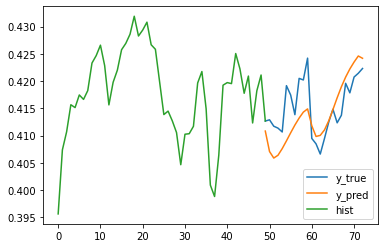

In [9]:
forecasts = np.array(forecasts)
forecasts = forecasts.reshape(forecast_window_len)
print(forecasts)

pyplot.plot(range(seq_len-1, seq_len+forecast_window_len-1), y[start_ind+seq_len-1:start_ind+seq_len+forecast_window_len-1], label='y_true')
pyplot.plot(range(seq_len-1, seq_len+forecast_window_len-1), forecasts, label='y_pred')
pyplot.plot(range(0, seq_len), y[start_ind:start_ind+seq_len], label='hist')

pyplot.legend()
pyplot.show()

# Test

In [10]:
y = df_test.pop("y").values.astype('float32')
X = df_test.values.astype('float32')

In [15]:
seq_len = 50
model = keras.models.load_model('best_model_50.h5')
forecast_window_len = 24
start_ind = 4500
model_input = X[start_ind:start_ind+seq_len]
forecasts = []
for pred_no in range(1, forecast_window_len+1):
    #print(model_input)
    #print("pred_no: ", model_input)
    #forecast = [[-666]] # 
    forecast = model(np.array([model_input]))
    forecasts.append(forecast[0][0])
    model_input = X[start_ind+pred_no:start_ind+pred_no+seq_len]
    #print("model_input", model_input[-(pred_no+1):, -1])
    #print("forecasts", forecasts)
    model_input[-pred_no:, -1] = np.array(forecasts) 

[0.37994215 0.38573563 0.38992488 0.39253187 0.35084146 0.34236944
 0.34716687 0.35461035 0.36424682 0.37581804 0.38782862 0.39877772
 0.407781   0.4145012  0.4189684  0.42085135 0.41398326 0.40798938
 0.4135895  0.42125127 0.42845583 0.43526533 0.44179398 0.447791  ]


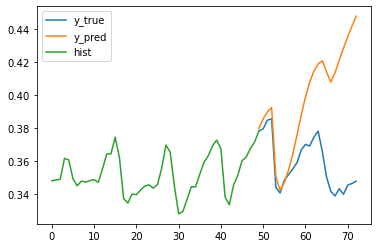

In [16]:
forecasts = np.array(forecasts)
forecasts = forecasts.reshape(forecast_window_len)
print(forecasts)

pyplot.plot(range(seq_len-1, seq_len+forecast_window_len-1), y[start_ind+seq_len-1:start_ind+seq_len+forecast_window_len-1], label='y_true')
pyplot.plot(range(seq_len-1, seq_len+forecast_window_len-1), forecasts, label='y_pred')
pyplot.plot(range(0, seq_len), y[start_ind:start_ind+seq_len], label='hist')

pyplot.legend()
pyplot.show()